In [1]:
import metmhn.simulations as simul
import metmhn.Utilityfunctions as utils
import pandas as pd
import numpy as np

import jax as jax
jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

Read in a saved metMHN:

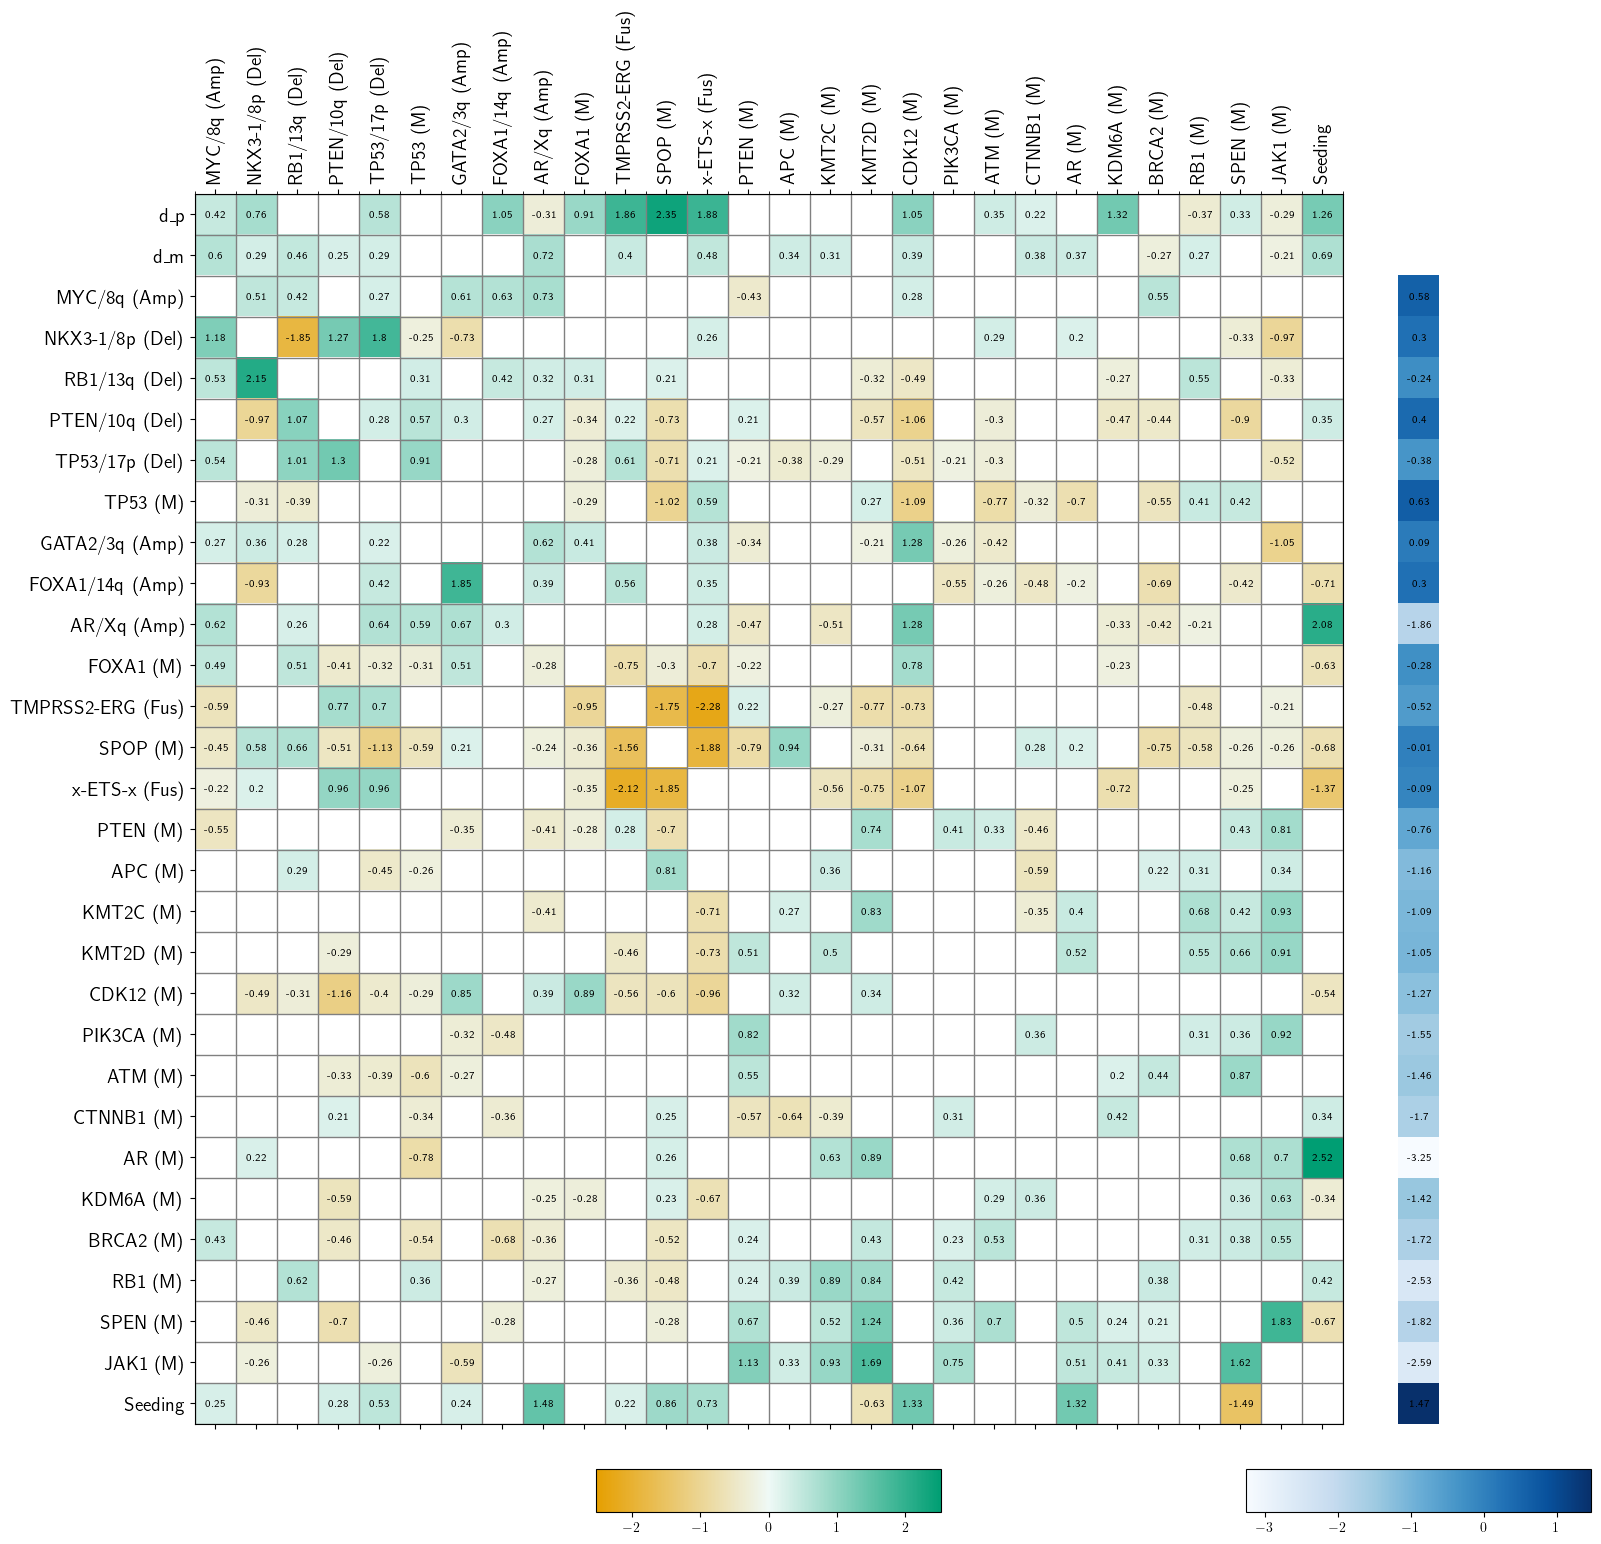

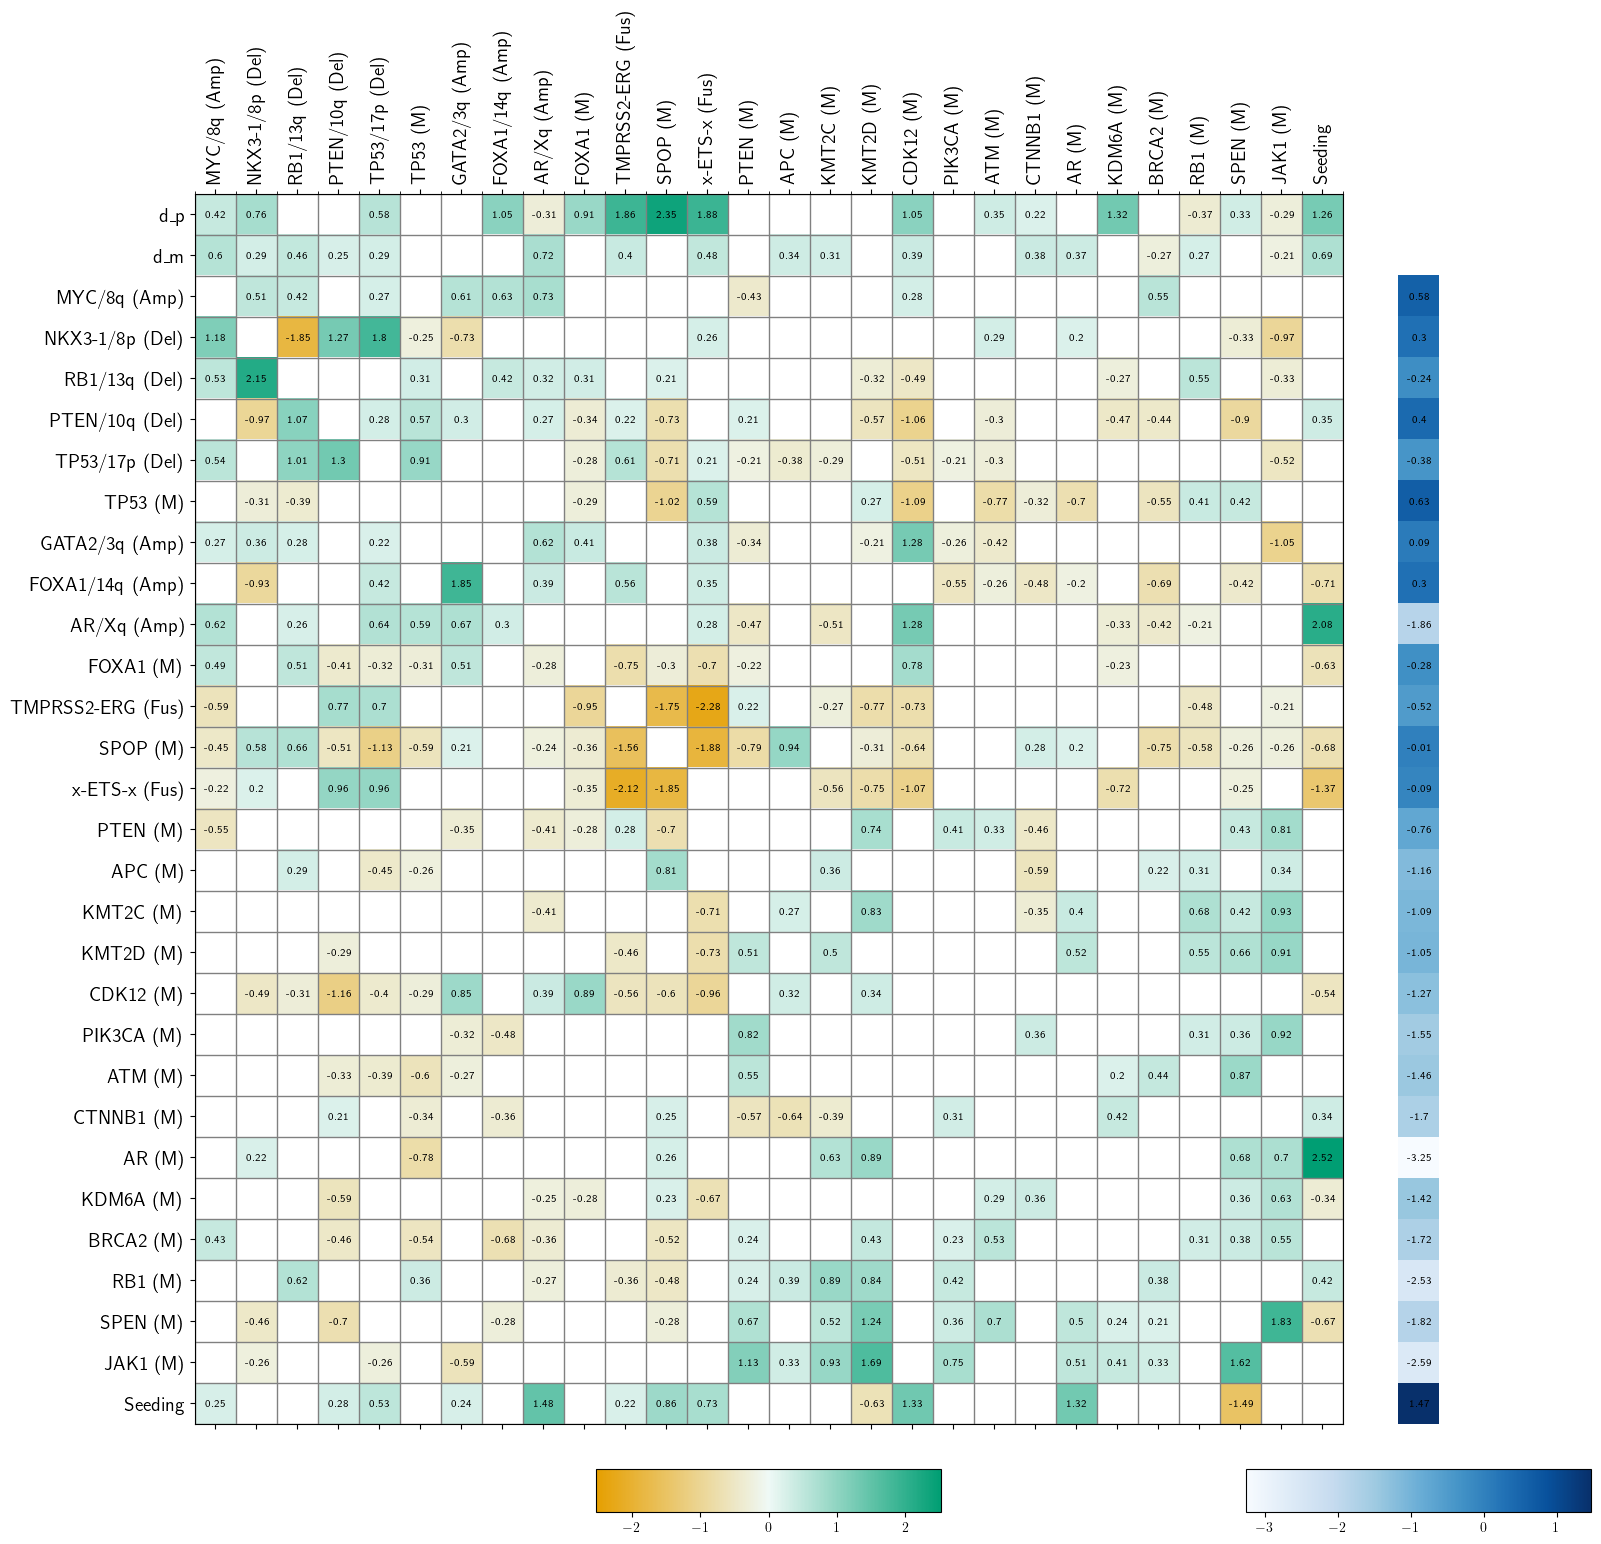

In [11]:
params = pd.read_csv("../results/prad/prad_g14_0001.csv", index_col=0)
d_p = params.iloc[0,:].to_numpy()
d_m = params.iloc[1, :].to_numpy()
th = params.iloc[2:,:].to_numpy()
events = params.columns
n = th.shape[1]
rng = np.random.default_rng(seed=42)
utils.plot_theta(params.to_numpy(), events, 0.2, True, 7.5)

Calculate $P(t_{mut} < t_{seed}| x[mut] = 1)$ i.e. the probability that a mutation happend prior to the seeding for both primary tumors and metastases:

In [ ]:
mut_ps, mut_total_prim, mut_total_met = simul.p_any_mut_pre_seed(np.array(th), np.array(d_p), np.array(d_m), 10000, rng)

In [ ]:
psp = pd.DataFrame(np.column_stack((mut_ps/mut_total_prim, mut_ps/mut_total_met)), 
                  index=events[:-1], columns=["PT", "MT"])
psp.sort_values(by=["PT"], inplace=True)
fig, ax = plt.subplots(figsize=(8.27, 11.69))

plt.style.use("default")
ax.set_xlim(0,1)
ax.axvline(0.5, color = "#D55E00", linestyle="dashed")
psp["PT"].plot(kind="barh", ax=ax, color="#D55E00")
ax.legend()

Simulate genotypes according to the model and compare them to the real data:

In [12]:
dat, ps = simul.simulate_dat(np.array(th), d_p, d_m, 10000, rng)
dat_prim_nomet = dat[dat[:,-2]==0,:-1]
dat_coupled = dat[dat[:,-2]==1,:-1]
dat_coupled.shape[0]/10000

0.6292

In [13]:
n_mut = (th.shape[0]-1)
n_tot = n_mut + 1
arr = dat_coupled * np.array([1,2]*n_mut+[1])
arr = arr @ (np.diag([1,0]*n_mut+[1]) + np.diag([1,0]*n_mut, -1))
counts = np.zeros((4, n_tot))
for i in range(0,2*n_tot,2):
    i_h = int(i/2)
    for j in range(1,4):
        counts[j-1, i_h] = np.count_nonzero(arr[:,i]==j)/dat_coupled.shape[0]
    counts[3, i_h] = np.sum(dat_prim_nomet[:, i], axis=0)/dat_prim_nomet.shape[0]

labels = [["Coupled ("+str(dat_coupled.shape[0])+")"]*3 +\
        ["NM ("+str(dat_prim_nomet.shape[0])+")"],
        ["PT-Private", "MT-Private", "Shared"] + ["Present"]*3]
       
inds =  pd.MultiIndex.from_tuples(list(zip(*labels)))
counts = pd.DataFrame(np.around(counts, 2), columns=events, index=inds).T
counts

Coupled (6292)                   NM (3708)
                      PT-Private MT-Private Shared   Present
MYC/8q (Amp)                0.08       0.32   0.28      0.29
NKX3-1/8p (Del)             0.09       0.31   0.25      0.32
RB1/13q (Del)               0.07       0.31   0.20      0.23
PTEN/10q (Del)              0.08       0.24   0.22      0.20
TP53/17p (Del)              0.08       0.23   0.18      0.17
TP53 (M)                    0.07       0.15   0.19      0.17
GATA2/3q (Amp)              0.08       0.18   0.16      0.17
FOXA1/14q (Amp)             0.12       0.11   0.14      0.26
AR/Xq (Amp)                 0.01       0.37   0.05      0.01
FOXA1 (M)                   0.06       0.06   0.07      0.13
TMPRSS2-ERG (Fus)           0.04       0.09   0.04      0.11
SPOP (M)                    0.05       0.05   0.07      0.17
x-ETS-x (Fus)               0.08       0.04   0.09      0.16
PTEN (M)                    0.03       0.04   0.05      0.06
APC (M)                     0.02       0.05   0.03      0.04
KMT2C (M)                   0.02       0.04   0.03      0.05
KMT2D (M)                   0.03       0.04   0.03      0.05
CDK12 (M)                   0.02       0.02   0.04      0.02
PIK3CA (M)                  0.01       0.03   0.02      0.03
ATM (M)                     0.02       0.03   0.02      0.04
CTNNB1 (M)                  0.01       0.04   0.02      0.03
AR (M)                      0.00       0.08   0.00      0.00
KDM6A (M)                   0.02       0.02   0.01      0.05
BRCA2 (M)                   0.01       0.02   0.02      0.03
RB1 (M)                     0.01       0.03   0.02      0.01
SPEN (M)                    0.01       0.01   0.01      0.04
JAK1 (M)                    0.01       0.02   0.01      0.02
Seeding                     1.00       0.00   0.00      0.00

Calculate $P(t_{mut} < t_{seed} | x[mut] = z[mut] = 1)$ ie. the probability that a **shared** mutation between the primary tumor and the metastasis happened prior to the seeding

In [ ]:
mut_ps, mut_total = simul.p_shared_mut_pre_seed(th, d_p, d_m, 10000, rng)
psp = pd.DataFrame(mut_ps/mut_total, index=events[:-1], columns=["Shared"])
psp.sort_values(by=["Shared"], inplace=True)
fig, ax = plt.subplots(figsize=(8.27, 11.69))
plt.style.use("default")
ax.set_xlim(0,1)
ax.axvline(0.5, color = "#D55E00", linestyle="dashed")
psp["Shared"].plot(kind="barh", color="#56B4E9", ax=ax)
ax.legend()